# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


In [54]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext blackcellmagic

font_manager.fontManager.addfont(
    "/home/chesmore/.local/share/fonts/HelveticaNeueLight.ttf"
)
matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update({"axes.grid" : False, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})
%config InlineBackend.figure_format = 'retina'

import imp
ot_geo = imp.load_source('ot_geo', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ot_geo.py')
ray_trace = imp.load_source('ray_trace', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/ray_trace.py')
opt_analyze = imp.load_source('opt_analyze', '/home/chesmore/Desktop/Code/SO SAT OT/sosat-optics/sosat_optics/opt_analyze.py')


tele_geo = ot_geo.LatGeo()
tele_geo.n_scan = 200
tele_geo.y_source = ot_geo.y_lyot + 300

output_rx = ray_trace.rx_to_lyot([0, 0, 0], tele_geo, 0, "b")

len_sim = int(np.sqrt(len(output_rx[0])))
x_sim = np.reshape(output_rx[0], (len_sim, len_sim))  # [mm]
y_sim = np.reshape(output_rx[2], (len_sim, len_sim))  # [mm]

indx_x = np.where((np.isnan(x_sim)==False) & (abs(x_sim)<=250))
indx_y = np.where((np.isnan(y_sim)==False) & (abs(y_sim)<=250))

x_sim_new = np.linspace(np.min(x_sim[indx_x]),np.max(x_sim[indx_x]),len_sim)
y_sim_new = np.linspace(np.min(y_sim[indx_y]),np.max(y_sim[indx_y]),len_sim)
x_sim,y_sim = np.meshgrid(x_sim_new,y_sim_new)

a_sim = np.reshape(output_rx[4], (len_sim, len_sim))
p_sim = np.reshape(output_rx[3], (len_sim, len_sim))
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3, 2 * np.pi)

# Define the complex beam from ray-trace outputs
noise = 1e-5 # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))

beam_sim = a_sim * np.exp(np.complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 18 # [mm]
apert2 = 19 # [mm]

# Convolve beam
x, y, beam_final = opt_analyze.beam_convolve(
    np.real(x_sim), np.real(y_sim), beam_sim, apert1, apert2
)

In [55]:
phase = np.arctan2(np.imag(beam_final),np.real(beam_final))
beam_fft,phase_fft = opt_analyze.b2a(abs(beam_final), phase)
freq = 150
x_ang,y_ang = opt_analyze.coords_spat_to_ang(x/1e3, y/1e3, freq)

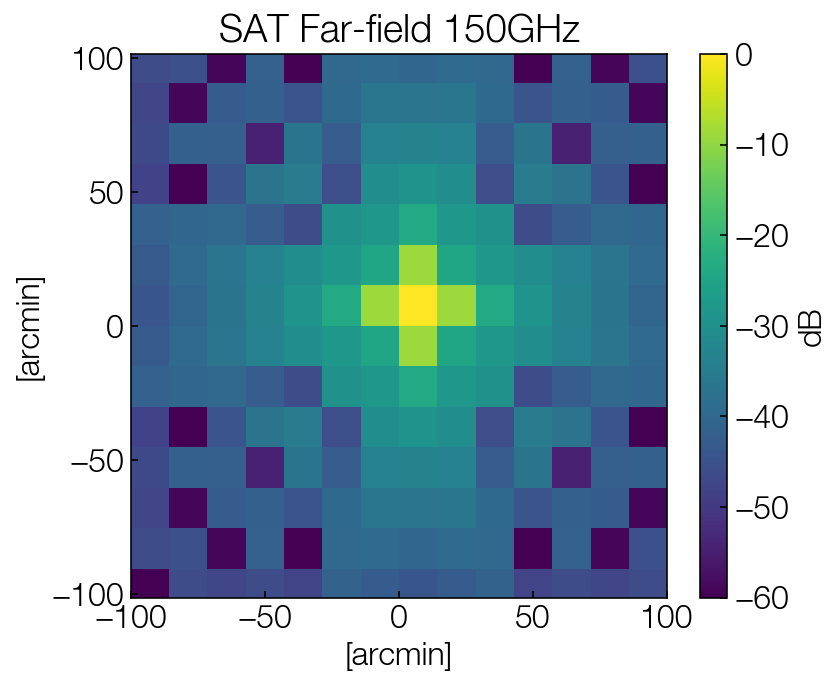

In [58]:
plt.figure(figsize = (6,5))
plt.title("SAT Far-field 150GHz")
plt.pcolormesh(x_ang*180*60/np.pi,y_ang*180*60/np.pi,20*np.log10(abs(beam_fft)/np.max(abs(beam_fft))),vmin = -60,shading = 'nearest')
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label = "dB")
plt.axis("equal")
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

In [36]:
# expected beam size at 150GHz (lambda = .001m)
print((1.22*.001 / .42)*180*60/np.pi)

9.98583585799435
